In [4]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
project_root = os.getenv('PROJECT_ROOT')

csv_path = os.path.join(project_root, 'data', 'raw', 'industry', 'WSTS-Historical-Billings-Monthly-Report-Aug2024.csv')

# Skip the first 3 rows (assuming 0-based indexing)
# Use row 3 (4th row) as the header
df = pd.read_csv(csv_path, skiprows=3, header=0)


In [5]:
print(df.head(10))
print(df.columns)
print(df.shape)


     Unnamed: 0    January   February      March      April        May  \
0          1986        NaN        NaN        NaN        NaN        NaN   
1      Americas    555,850    633,465    756,220    689,470    718,336   
2        Europe    346,467    401,765    461,912    436,798    446,171   
3         Japan    638,547    750,366    840,215    838,082    870,515   
4  Asia Pacific    105,050    115,746    147,968    156,420    167,537   
5     Worldwide  1,645,914  1,901,342  2,206,315  2,120,770  2,202,559   
6          1987        NaN        NaN        NaN        NaN        NaN   
7      Americas    662,316    695,384    879,953    783,070    819,071   
8        Europe    446,216    460,982    551,635    483,195    522,679   
9         Japan    839,651    885,850    947,246    937,335    980,361   

        June       July     August  September    October   November  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1    797,014    707,784    697,506    803,3

In [6]:
processed_data = []


In [7]:
current_year = None

for index, row in df.iterrows():
    first_cell = row.iloc[0]
    
    if pd.isnull(first_cell):
        continue  # Skip empty rows
    
    if isinstance(first_cell, str) and first_cell.strip().isdigit():
        # This row contains the year
        current_year = int(first_cell.strip())
        continue  # Move to the next row
    
    if current_year is None:
        continue  # Skip rows until we have a year
    
    region = first_cell.strip()
    # Extract the billing data for this region
    billing_data = row.iloc[1:]  # Skip the first cell (region name)
    
    # Create a DataFrame for this region and year
    months = df.columns[1:]  # Exclude the first column (region/year labels)
    data = {'Year': current_year, 'Region': region}
    
    for month, value in zip(months, billing_data):
        data_point = data.copy()
        data_point['Month'] = month
        data_point['Billing'] = value
        processed_data.append(data_point)


In [8]:
# Convert the list of dictionaries to a DataFrame
processed_df = pd.DataFrame(processed_data)


In [9]:
processed_df['Billing'] = pd.to_numeric(processed_df['Billing'].str.replace(',', ''), errors='coerce')


In [10]:
processed_df.dropna(subset=['Billing'], inplace=True)


In [11]:
# If month names are full names (e.g., 'January', 'February'), map them directly
# If they are abbreviations or have typos, create a mapping dictionary
month_mapping = {
    'January': '01', 'February': '02', 'March': '03', 'April': '04',
    'May': '05', 'June': '06', 'July': '07', 'August': '08',
    'September': '09', 'October': '10', 'November': '11', 'December': '12',
    'Total Year': None, 'Q1': None, 'Q2': None, 'Q3': None, 'Q4': None
}

processed_df['Month_Number'] = processed_df['Month'].map(month_mapping)


In [12]:
# Remove rows where 'Month_Number' is None (i.e., 'Total Year', 'Q1', etc.)
processed_df = processed_df[processed_df['Month_Number'].notnull()]


In [13]:
processed_df['Date'] = pd.to_datetime(processed_df['Year'].astype(str) + '-' + processed_df['Month_Number'] + '-01')


In [14]:
processed_df.drop(columns=['Year', 'Month', 'Month_Number'], inplace=True)


In [15]:
processed_df.set_index('Date', inplace=True)


In [16]:
print(processed_df.head())
print(processed_df.info())


              Region   Billing
Date                          
1986-01-01  Americas  555850.0
1986-02-01  Americas  633465.0
1986-03-01  Americas  756220.0
1986-04-01  Americas  689470.0
1986-05-01  Americas  718336.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2320 entries, 1986-01-01 to 2024-08-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Region   2320 non-null   object 
 1   Billing  2320 non-null   float64
dtypes: float64(1), object(1)
memory usage: 54.4+ KB
None


In [17]:
pivot_df = processed_df.pivot_table(values='Billing', index=processed_df.index, columns='Region')



In [18]:
# Define the path to save the processed data
processed_data_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(processed_data_dir, exist_ok=True)

# Save as CSV
processed_df.to_csv(os.path.join(processed_data_dir, 'global_billings_processed.csv'))

# If you created the pivoted DataFrame
pivot_df.to_csv(os.path.join(processed_data_dir, 'global_billings_pivot.csv'))


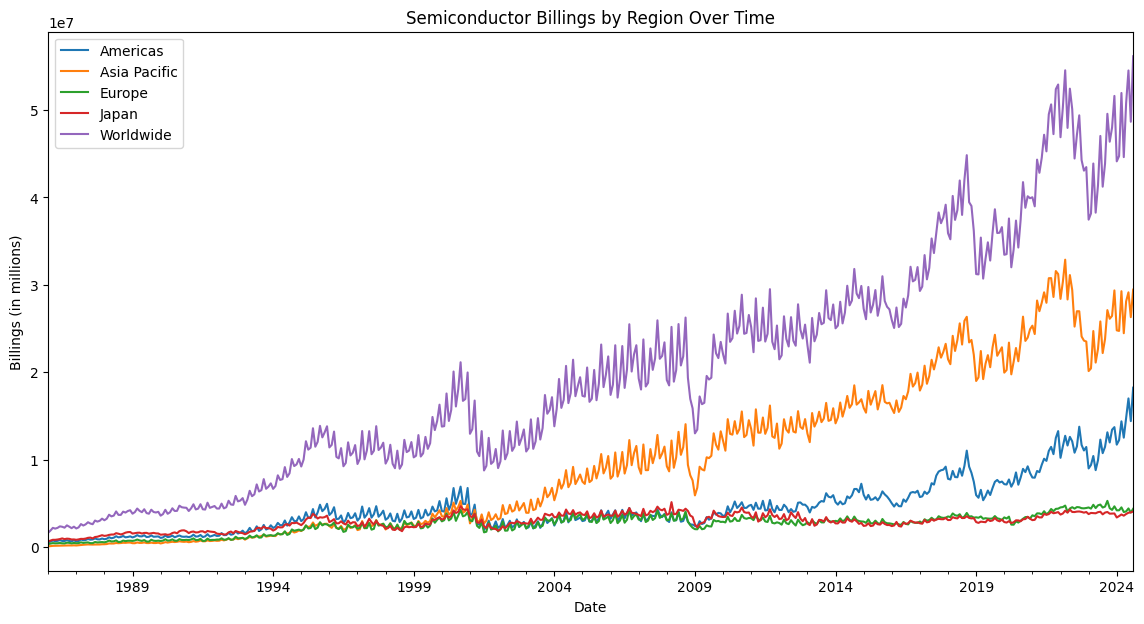

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# If using the pivoted DataFrame
pivot_df.plot(figsize=(14, 7))
plt.title('Semiconductor Billings by Region Over Time')
plt.xlabel('Date')
plt.ylabel('Billings (in millions)')
plt.legend()
plt.show()


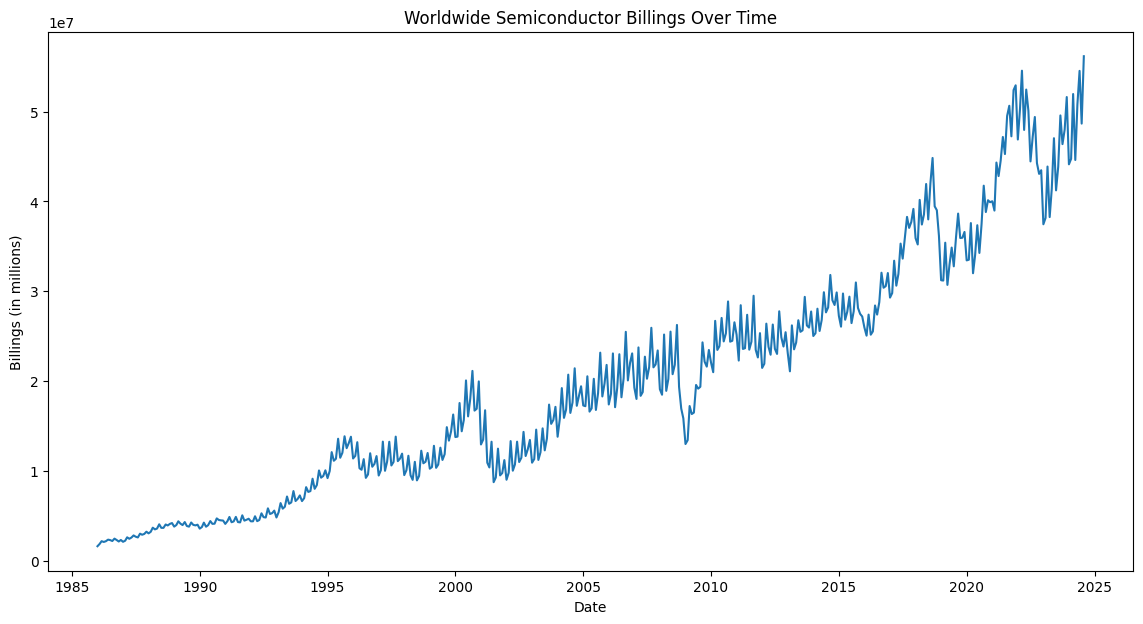

In [20]:
worldwide_df = processed_df[processed_df['Region'] == 'Worldwide']

plt.figure(figsize=(14, 7))
plt.plot(worldwide_df.index, worldwide_df['Billing'])
plt.title('Worldwide Semiconductor Billings Over Time')
plt.xlabel('Date')
plt.ylabel('Billings (in millions)')
plt.show()


In [21]:
# Load macroeconomic data
macro_df = pd.read_csv(os.path.join(project_root, 'data', 'processed', 'macro_data_processed.csv'), parse_dates=['Date'], index_col='Date')

# Merge with worldwide billings
combined_df = worldwide_df.join(macro_df, how='inner')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ehbai\\Documents\\chips\\data\\processed\\macro_data_processed.csv'